In [2]:
from fastai.vision.all import *

### 데이터 준비
- 이미지 회귀 문제를 예제로 다룰 거야.
- 나이, 좌표처럼 **연속된 수치**를 예측하는 것을 회귀라고 해.

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [5]:
path.ls()
# 디렉터리 24개로 구성돼.

(path/'01').ls()
# 디렉터리 중 하나를 선택해 살펴보면 한 사람의 서로 다른 프레임을 나타내는 사진들이 있어.

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00152_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00108_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00282_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00043_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00428_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00072_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00288_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00338_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00491_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00200_pose.txt')...]

In [8]:
# 이미지 파일을 다운로드해서 이미지를 살펴볼거야.
img_files = get_image_files(path)
im = PILImage.create(img_files[0])
im.shape

(480, 640)

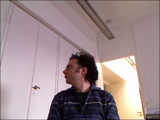

In [9]:
im.to_thumb(160)

In [20]:
# 이미지 파일명에 해당하는 포즈 파일명을 반환하는 함수야.
# 포즈 파일명을 반환하는 함수를 만드는 이유는
# '머리 중심 위치를 추출하는 함수/를 정의할 때 '포즈 파일명'이 필요하기 때문이야.

def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')

str(img_files[0]), img2pose(img_files[0])
# 살펴보면, 이미지 파일명에서 rgb.jpg 부분을 pose.txt 로 바꾼 것 뿐이야.

('/root/.fastai/data/biwi_head_pose/20/frame_00043_rgb.jpg',
 Path('/root/.fastai/data/biwi_head_pose/20/frame_00043_pose.txt'))

In [22]:
# 파일에서 머리의 중심 위치를 추출하는 함수를 정의해야해.
# DataBlock에서 get_y에 해당하는 함수가 될거야.

cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)


def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])

get_ctr(img_files[0])
# 좌표 요소가 둘인 텐서를 반환해.

tensor([301.2149, 280.5131])

### 데이터블락 만들기
- 블록: 두 번째 블록으로 PointBlock을 사용해. 이 블록을 사용하면 fastai는 레이블이 **좌표**로 표현된다는 사실을 파악해.
- 학습용/검증용: 검증용 데이터셋으로는 한 사람의 이미지만 사용할거야. 그래야 모델 학습에서 본 적 없는 사람의 데이터로 검증할 수 있어.

In [24]:
biwi = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms = [*aug_transforms(size=(240,320)),
             Normalize.from_stats(*imagenet_stats)])

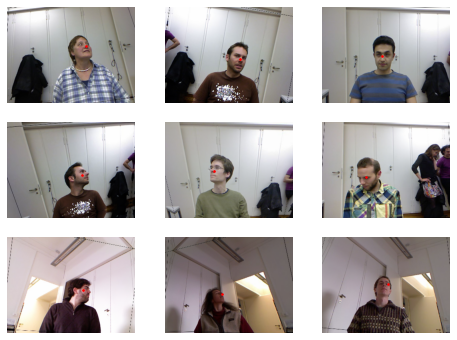

In [25]:
# 모델링하기 전에 이미지와 레이블 데이터가 정상인지 확인해.

dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [49]:
# 미니배치의 모양도 확인할거야.

xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

**xb 모양 [64, 3, 240, 320]**
- 64: 배치 크기(batch size), 즉 한 번에 처리되는 이미지 샘플의 수야.
- 3: 이미지 채널 수. 대부분의 컬러 이미지는 RGB 채널이 3개이므로, 각 이미지는 3개의 채널을 가져. [ [R], [G], [B] ]
- 240: 이미지의 높이(height). 이미지의 픽셀 수를 나타내.
- 320: 이미지의 너비(width). 이미지의 픽셀 수를 나타내.
- 따라서, 각각의 미니배치에는 64개의 이미지가 포함되고, 각 이미지는 3개의 채널을 가진 240x320 크기의 이미지야.

**yb의 모양 [64, 1, 2]**
- 64: 배치 크기(batch size), 즉 한 번에 처리되는 예측값 샘플의 수야.
- 1: 각 예측값은 하나의 좌표 쌍(머리의 x와 y 좌표)을 가져. [ [좌표] ]
- 2: 각 좌표 쌍은 2개의 요소(x와 y)로 구성됩니다. [x,y]
- 따라서, 각 미니배치에는 64개의 예측값이 포함되며, 각 예측값은 머리의 x와 y 좌표를 나타내는 2개의 숫자로 이루어져 있어.

In [28]:
yb[0]

TensorPoint([[-0.1953, -0.1376]], device='cuda:0')

### 모델 학습

In [29]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**y_range 인자**
- 항상 좌푯값이 -1과 1 사이의 범위이도록 조정해야해.
- fastai는 **sigmoid_range**함수로 y_range를 구현해.

In [30]:
def sigmoid_range(x, lo, hi):
    return torch.sigmoid(x) * (hi-lo) + lo

# (0~1) * 2 + (-1) ==> (0~2) + (-1) ==> (-1~1) 사이값이 나와.

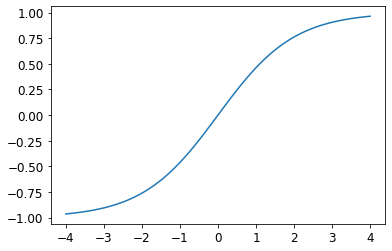

In [44]:
# 모델의 출력 활성화 범위를 (lo, hi)로 강제하는 이유가 뭘까?
# 범위를 -1~1로 강제하면 이런 그래프가 나와.
# 좌표 값을 제한 범위 내에 놓아야 좋은 예측을 수행할 수 있어.
plot_function(partial(sigmoid_range, low=-1, high=1), min=-4, max=4)

In [45]:
# 손실 함수를 따로 지정하지 않았어.
# fastai가 자동으로 선택한 손실 함수가 뭘까?
# 평균제곱근오차 손실. 주어진 좌표에서 가능한 한 가까운 값을 예측할 때 사용하는 함수야.

dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0030199517495930195)

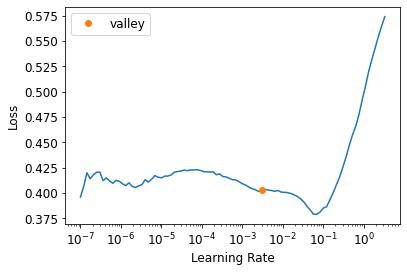

In [46]:
# 학습률 발견자로 적당한 학습률을 찾을 거야.

learn.lr_find()

In [47]:
# 10의 -2승, 즉 1e-2를 학습률로 사용하면 좋을 것 같아.

lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.046013,0.017922,01:07


epoch,train_loss,valid_loss,time
0,0.007637,0.000895,01:25
1,0.003079,0.000216,01:25
2,0.001520,0.000086,01:25


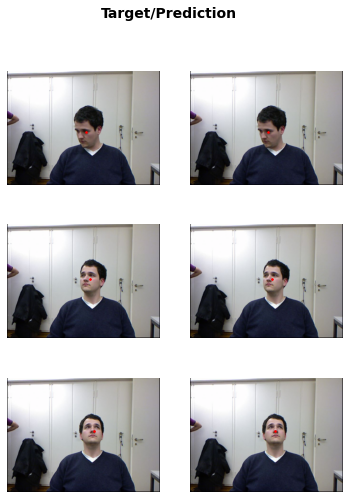

In [48]:
# 실제 과정을 눈으로 확인할거야.
# 좌측은 실제 좌표, 우측은 모델이 예측한 좌표야.

learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))